# 훈련 후 정수 양자화

* https://www.tensorflow.org/lite/performance/post_training_integer_quant

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU[0] is ready')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)
else:
    print('Please check GPU available')
    
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
import tensorflow_datasets as tfds
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY

GPU[0] is ready


In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

assert float(tf.__version__[:3]) >= 2.3

In [17]:
train_images.dtype

dtype('float64')

# 일반 학습으로 MNIST 모델 생성 후 저장

In [44]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images, test_images = train_images.astype(np.float32)/255., test_images.astype(np.float32)/255.


# Define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28)),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_data=(test_images, test_labels)
)

Epoch 1/10
1875/1875 [==============================] - 2s 867us/step - loss: 0.3149 - accuracy: 0.9086 - val_loss: 0.1917 - val_accuracy: 0.9448
Epoch 2/10
1875/1875 [==============================] - 2s 822us/step - loss: 0.1556 - accuracy: 0.9546 - val_loss: 0.1114 - val_accuracy: 0.9687
Epoch 3/10
1875/1875 [==============================] - 2s 827us/step - loss: 0.1014 - accuracy: 0.9707 - val_loss: 0.0826 - val_accuracy: 0.9748
Epoch 4/10
1875/1875 [==============================] - 2s 837us/step - loss: 0.0774 - accuracy: 0.9776 - val_loss: 0.0702 - val_accuracy: 0.9784
Epoch 5/10
1875/1875 [==============================] - 2s 837us/step - loss: 0.0636 - accuracy: 0.9812 - val_loss: 0.0640 - val_accuracy: 0.9789
Epoch 6/10
1875/1875 [==============================] - 2s 851us/step - loss: 0.0557 - accuracy: 0.9834 - val_loss: 0.0580 - val_accuracy: 0.9815
Epoch 7/10
1875/1875 [==============================] - 2s 836us/step - loss: 0.0501 - accuracy: 0.9845 - val_loss: 0.0606 -

# TensorFlow Lite 모델로 변환하기  (FP32)

In [45]:
tflite_models_dir = pathlib.Path("/tmp/logs/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp6071f8uc/assets


INFO:tensorflow:Assets written to: /tmp/tmp6071f8uc/assets


84528

In [47]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

# INT8 양자화된 모델로 저장하기, 완전 정수화 모델  => 1/4 크기

In [48]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpuyz6l8vu/assets


INFO:tensorflow:Assets written to: /tmp/tmpuyz6l8vu/assets


In [49]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24784

In [50]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [51]:
# 입출력은 UINT8
in_dtype = interpreter_quant.get_input_details()[0]['dtype']
out_dtype = interpreter_quant.get_output_details()[0]['dtype']
print(f'input dtype: {in_dtype}, output dtype: {out_dtype}')

input dtype: <class 'numpy.uint8'>, output dtype: <class 'numpy.uint8'>


In [52]:
interpreter_quant.get_input_details()[0]['quantization_parameters']

{'scales': array([0.00392157], dtype=float32),
 'zero_points': array([0], dtype=int32),
 'quantized_dimension': 0}

In [53]:
interpreter_quant.get_output_details()[0]['quantization_parameters']

{'scales': array([0.21143739], dtype=float32),
 'zero_points': array([180], dtype=int32),
 'quantized_dimension': 0}

# 정수형 입력을 사용하여 TensorFlow Lite 모델 예측 수행하기

In [54]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)
print(f'test image shape: {test_images[0].shape}')

test image shape: (28, 28)


In [94]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        # Check if the output type is quantized, then rescale output data to float
        if output_details['dtype'] == np.uint8:
            output_scale, output_zero_point = output_details["quantization"]
            test_image = test_image.astype(np.float32)
            test_image = test_image / input_scale + input_zero_point

        predictions[i] = output.argmax()

    return predictions

In [95]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 9874

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
    global test_labels

    predictions = run_tflite_model(tflite_file, [test_image_index])

    plt.imshow(test_images[test_image_index])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
    plt.grid(False)

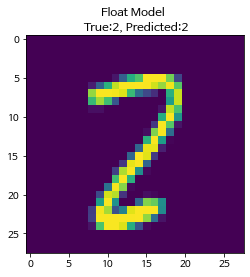

In [96]:
## F32 모델의 경우 
test_model(tflite_model_quant_file, test_image_index, model_type="Float")

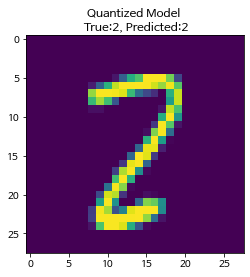

In [97]:
## 정수형 모델의 경우
test_model(tflite_model_file, test_image_index, model_type="Quantized")

# 모든 파일 예측해서 성능 비교

In [100]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels
   
    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)
      
    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
        model_type, accuracy, len(test_images)))

In [101]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 98.2300% (Number of test samples=10000)


In [102]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 98.1800% (Number of test samples=10000)
